In [ ]:
!pip3 install transformers timm supervision pytorch_lightning coco_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for coco_eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5015 sha256=7634940b12a7026c64cc0ce422e35b70676767a6e49ffc4584d7b3f3c0ee62d3
  Stored in directory: /root/.cache/pip/wheels/84/b3/4e/028c9f6224a7d8a3ed8023224283820e90d489010f3c77ea13
Successfully built coco_eval


In [34]:
import os
from matplotlib import pyplot as plt

HOME = os.getcwd()
print(HOME)

/content


### Load Model

In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

# load dataset

In [ ]:
 !git clone https://github.com/Ala-Alsanea/sketch_web_ui_dataset.git

In [ ]:
!cd sketch_web_ui_dataset &&  python3 setup.py

In [ ]:
!python3 sketch_web_ui_dataset/create_new_dataset_and_preprocess.py -p sketch_web_ui_dataset

In [ ]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "annotations.coco.json"
TRAIN_DIRECTORY = os.path.join('sketch_web_ui_dataset', "train",'images')
VAL_DIRECTORY = os.path.join('sketch_web_ui_dataset', "train",'images')
TEST_DIRECTORY = os.path.join('sketch_web_ui_dataset', "test",'images')


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        print(annotation_file_path)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY, 
    image_processor=image_processor, 
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

## Visualize data entry

Image #55


<ipython-input-36-7c266028c866>:20: DeprecationWarning: from_coco_annotations is deprecated: Dataset loading and saving is going to be executed by supervision.dataset.core.Dataset
  detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)


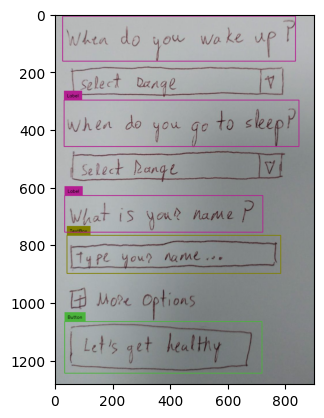

In [36]:
import random
import cv2
import numpy as np
import supervision as sv



# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, _,class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline   
plt.imshow(image)
plt.show()
# sv.show_frame_in_notebook(image, (16, 16))

In [20]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

## Train model with PyTorch Lightning

**NOTE:** Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrImageProcessor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [23]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
%cd {HOME}
%mkdir lightning_logs
%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir lightning_logs/

In [25]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
# print(batch)
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
outputs.logits.shape

torch.Size([4, 100, 12])

In [ ]:
from pytorch_lightning import Trainer

%cd {HOME}

# settings
MAX_EPOCHS = 5

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, 
                  accelerator="gpu", 
                  max_epochs=MAX_EPOCHS, 
                  gradient_clip_val=0.1, 
                  accumulate_grad_batches=4, 
                  log_every_n_steps=5)



In [30]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.048   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
model.to(DEVICE)

Image #54
ground truth


<ipython-input-35-ce17ba3cbcc5>:23: DeprecationWarning: from_coco_annotations is deprecated: Dataset loading and saving is going to be executed by supervision.dataset.core.Dataset
  detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)


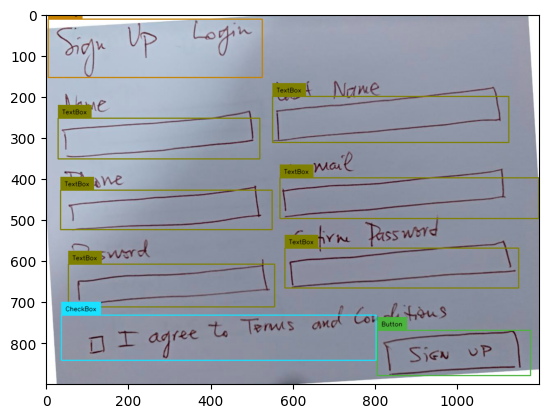

detections


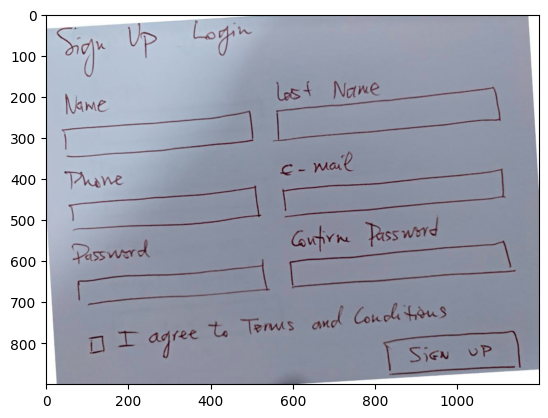

In [35]:
import random
import cv2
import numpy as np


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, _,class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline 
plt.imshow(frame)
plt.show() 
# sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline  
plt.imshow(frame)
plt.show()
# sv.show_frame_in_notebook(frame, (16, 16))

## Evaluation on test dataset

Finally, we evaluate the model on the `TEST_DATASET`. For this we make use of the `CocoEvaluator` class available in a tiny [PyPi package](https://github.com/NielsRogge/coco-eval) made by [Niels Rogge](https://github.com/NielsRogge) . This class is entirely based on the [original evaluator](https://github.com/facebookresearch/detr/blob/main/datasets/coco_eval.py) class used by the DETR authors.

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
# TEST_DATASET.transforms

In [ ]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=TEST_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(TEST_DATALOADER)):
    pixel_values = batch["pixel_values"].to(DEVICE)
    pixel_mask = batch["pixel_mask"].to(DEVICE)
    labels = [{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

## Save and load model

In [ ]:
MODEL_PATH = os.path.join(HOME, 'custom-model-DETR')

In [ ]:
model.model.save_pretrained(MODEL_PATH)

In [ ]:
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model

In [ ]:
[{k: v.to(DEVICE) for k, v in t.items()} for t in batch["labels"]][0].keys()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')